In [156]:
import networkx as nx
import numpy as np
import random

#!pip install snscrape
import snscrape.modules.twitter as sntwitter
import pandas as pd
import re
import time
import pickle
import os
import matplotlib.pyplot as plt
from scipy.stats import poisson, levy_stable

# Task 1

## Random graph


In [118]:
#There will be Erdos-Renyi model, for graph with fixed number of links L between N nodes 
def Ernyi(N=20, L=20):
    if(L>N*(N-1)/2):
        raise ValueError ("To many edges!") # of course we cannot create matrix of 3 nodes with 4 edges
    G = nx.Graph()
    G.add_nodes_from([i+1 for i in range(N)]) #so we can start from 1
    iterator = 0
    while(iterator<L):
        #for_choice = [i for i in G.nodes]
        #i = random.choice(for_choice)
        #for_choice.remove(i)
        #j = random.choice(for_choice)
        [i,j] = random.sample(list(G.nodes), 2) #we take two nodes
        if not((i, j) in G.edges):
            G.add_edge(i, j) #we add
        else: #to maintain proper number of links
            iterator = iterator-1 
        iterator = iterator + 1
    #nx.draw_circular(G)
    return G

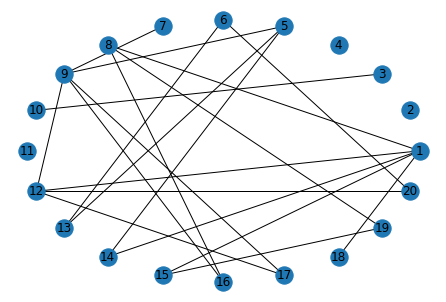

In [124]:
nx.draw_circular(Ernyi(20, 20), with_labels=True)

In [120]:
Ern_graph = Ernyi(20, 40)

40


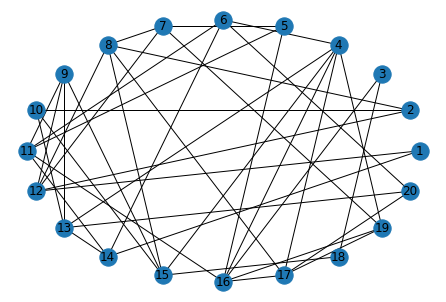

In [126]:
nx.draw_circular(Ern_graph, with_labels=True)
print(len(Ern_graph.edges))

# Watts-Strogatz model

In [104]:
#N is number of nodes, k is number of closest neighbours and p is probability that we change edge in single step
def Watatz(N=20, k=4, p=1):
    if(k%2==1):
        raise ValueError ("Need even number of closest neighbours!")
    
    #creates starting graph//do not move
    G = nx.Graph()
    #N = N-1 #because we start from 0
    G.add_nodes_from([i for i in range(N)])
    print(G.nodes)
    for i in G.nodes:
        for ki in range(int(k/2)):
            G.add_edges_from([((i+N-1-ki)%N,i), ((i+N+1+ki)%N,i)]) #calculations so N-1 is connected with 0
    
    #from here possible changes
    #changes link for each
    new_G = nx.Graph()
    iterator = 0

    for link in G.edges:
        #relinking
        if(random.random()<p): #if we succeed in relinking
            new_link = link #for now it is as before
            if(random.random()<0.5): #whether relink node 1 or 2 from edge
                #we do not want link that already was in network, not that we have in currently created one
                while(new_link in list(G.edges)[iterator:] or new_link in new_G.edges):
                    for_choice = list(G.nodes)
                    for_choice.remove(new_link[0])
                    relink = random.choice(for_choice)
                    new_link = (new_link[0], relink)
                new_G.add_edge(new_link[0], new_link[1])
            else:
                while(new_link in list(G.edges)[iterator:] or new_link in new_G.edges):
                    for_choice = list(G.nodes)
                    for_choice.remove(new_link[1])
                    relink = random.choice(for_choice)
                    new_link = (relink, new_link[1])
                new_G.add_edge(new_link[0], new_link[1])
        else:
            new_G.add_edge(link[0], link[1])
        iterator = iterator+1
        
    new_G.add_nodes_from(list(G.nodes)) #in case some node got totally unconnected
    #nx.draw_circular(G)
    return new_G

In [110]:
G = Watatz(10, 4,0)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


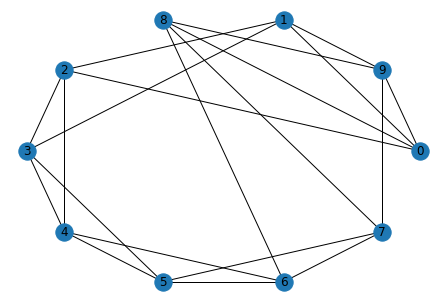

In [112]:
nx.draw_circular(G, with_labels=True) #looks a bit weird, but it only 0 mispositioned

In [83]:
G.nodes

NodeView((0, 11, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10))

# Barabasi model

In [70]:
''' we start with m0 nodes and in each step we add node connected to m<m0 previous nodes until we reach N nodes
    after t steps we should have N=m0+t nodes and E=m0+mt edges
'''
def Barabasi(m0, m, t):
    '''creating, start from 1 to be similar with previous ones
        we want to start with m0 nodes, m0 edges and each link connected,
        so I just start with triangle, then add new linked nodes'''
    
    G = nx.Graph()
    G.add_edges_from([(1,2), (1,3), (2,3)])
    for i in range(3,m0+1): 
        G.add_edge(i, random.choice(list(G.nodes)))
        
    #now we add new nodes, choose m distinct edges coming from new node
    for tau in range(t):
        choice_list =  random.sample(list(G.nodes), m)
        for link in choice_list:
            G.add_edge(link, tau+m0+1)
      
    return G

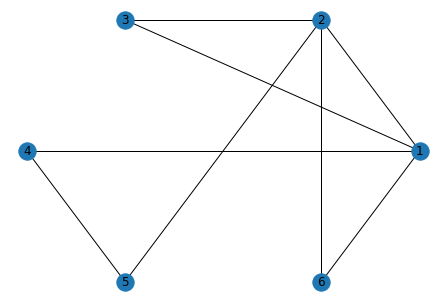

In [90]:
easy_to_check = Barabasi(m0=4, m=2, t=2)
nx.draw_circular(easy_to_check, with_labels=True) 

In [91]:
Bari_graph = Barabasi(m0=4, m=2, t=16)

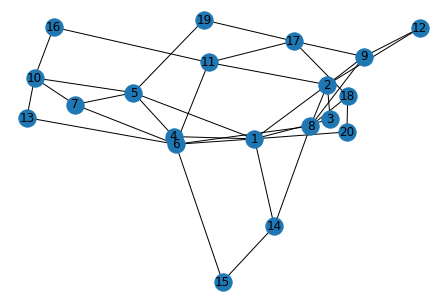

In [68]:
nx.draw_spectral(Bari_graph, with_labels=True) 

## Reports

In [ ]:
'''We have 
Ernyi(N=nodes, L=links) for random graph
Watatz(N=nodes, k=starting neighbours, p=P(relinking each edge))
Barabasi(m0=starting nodes/edges, m=added edges each time, t=times we add)
'''

### Random

In [183]:
def check_info(G):
    print('Number of nodes:', len(random_graph.nodes), ' and number of edges:', len(random_graph.edges))
    
    degrees = []
    for node in G.nodes:
        degrees.append(sum(node in edge for edge in G.edges))
    g_mean = np.mean(degrees)
    g_var = sum([(i-g_mean)**2 for i in degrees])/(len(degrees)-1)
    print('Mean degree:', g_mean, 'and variance:', g_var)
    
    min_d = min(degrees)
    max_d = max(degrees)
    x_stem = []
    y_stem = []
    for step in range(min_d, max_d+1):
        x_stem.append(step)
        y_stem.append(sum([deg==step for deg in degrees]))
    
    fig, ax = plt.subplots()
    ax.stem(x_stem, y_stem)
    ax.set_title('Frequency plot')
    
    #dist
    z_stem=[]
    for i in y_stem:
        z_stem.append(i/len(G.nodes))
    ran = range(min_d, max_d+1)
    vals = [poisson.pmf(i, g_mean) for i in ran]
    fig, ax2 = plt.subplots()
    ax2.stem(x_stem, z_stem)
    ax2.plot(ran, vals, color='green', label='Poisson dist')
    ax2.set_title('Model - Poisson dist mith mean')
    ax2.legend()
    

In [185]:
random_graph = Ernyi(20, 40)

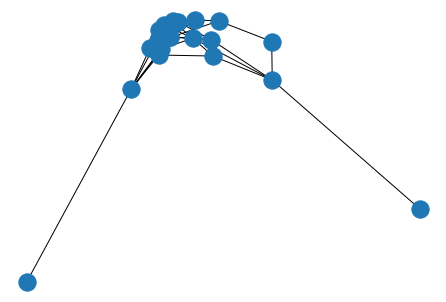

In [197]:
nx.draw_spectral(random_graph)

Number of nodes: 20  and number of edges: 40
Mean degree: 4.0 and variance: 3.1578947368421053


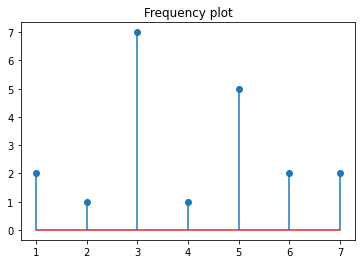

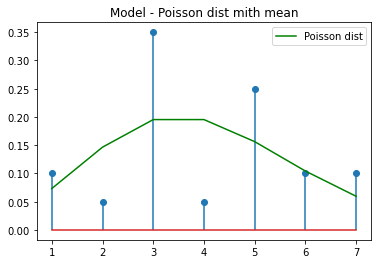

In [186]:
check_info(random_graph)

In [191]:
watatz_graph = Watatz(20, 6, 0.4)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]


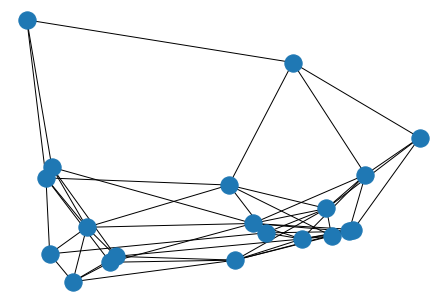

In [194]:
nx.draw_spectral(watatz_graph)

Number of nodes: 20  and number of edges: 40
Mean degree: 5.8 and variance: 2.063157894736842


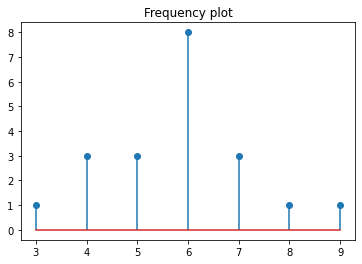

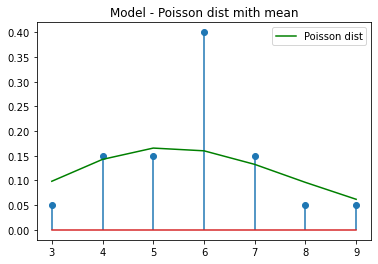

In [192]:
check_info(watatz_graph)

In [189]:
barabasi_graph = Barabasi(3, 3, 17)

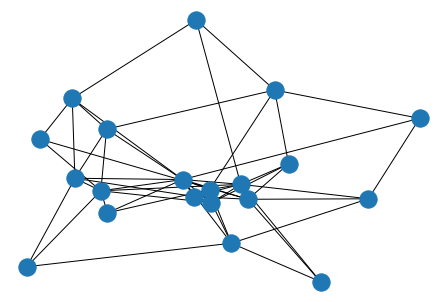

In [193]:
nx.draw_spectral(barabasi_graph)

Number of nodes: 20  and number of edges: 40
Mean degree: 5.4 and variance: 6.042105263157896


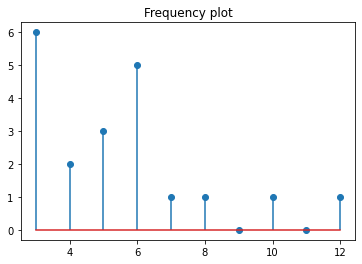

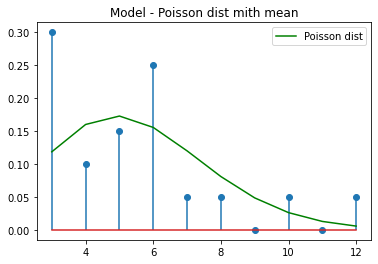

In [190]:
check_info(barabasi_graph)